In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [2]:
def percent_scaling(series):
    return (series / 100)

def cpu_scaling(series):
    return (series * 4 / 100)

def single_cpu_scaling(series):
    return (((series - 100) * (-1)) / 100)

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

In [3]:
cpu_df = pd.read_csv('../results/numa-matrix.csv')

cpu_df['cache_hit_rate_0'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_0']) / cpu_df['cache_hit_0']
cpu_df['cache_hit_rate_1'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_1']) / cpu_df['cache_hit_1']
cpu_df['cache_hit_rate_2'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_2']) / cpu_df['cache_hit_2']
cpu_df['cache_hit_rate_3'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_3']) / cpu_df['cache_hit_3']

cpu_df['br_miss_rate_0'] = cpu_df['br_miss_0'] / cpu_df['br_insns_0']
cpu_df['br_miss_rate_1'] = cpu_df['br_miss_1'] / cpu_df['br_insns_1']
cpu_df['br_miss_rate_2'] = cpu_df['br_miss_2'] / cpu_df['br_insns_2']
cpu_df['br_miss_rate_3'] = cpu_df['br_miss_3'] / cpu_df['br_insns_3']

cpu_df['insns_0_norm'] = cpu_df['insns_0'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['insns_1_norm'] = cpu_df['insns_1'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['insns_2_norm'] = cpu_df['insns_2'] / (cpu_df['time'] - cpu_df['time'].shift())
cpu_df['insns_3_norm'] = cpu_df['insns_3'] / (cpu_df['time'] - cpu_df['time'].shift())

cpu_df = cpu_df.drop(index=0)
cpu_df

,time,current,cpu_cycles_0,insns_0,cache_hit_0,cache_miss_0,br_insns_0,br_miss_0,bus_cycles_0,freq_0,...,cache_hit_rate_2,cache_hit_rate_3,br_miss_rate_0,br_miss_rate_1,br_miss_rate_2,br_miss_rate_3,insns_0_norm,insns_1_norm,insns_2_norm,insns_3_norm
1,2691,1.944,41410,17962,6689,49,1839,269,12316,1000000,...,2.104964,0.095378,0.146275,0.145540,0.145161,0.071332,10.985933,5.401835,5.400000,89.125994
2,4241,1.944,34196,15660,5781,47,1506,217,8640,1000000,...,1.798876,0.082494,0.144090,0.142410,0.136150,0.066108,10.103226,6.045806,6.045161,91.874194
3,5791,1.944,34102,15662,5788,47,1504,215,8694,1000000,...,1.799813,0.081686,0.142952,0.133020,0.133020,0.065680,10.104516,6.018710,6.044516,93.468387
4,7334,1.944,34136,15662,5786,43,1506,212,8704,1000000,...,1.799188,0.082869,0.140770,0.133020,0.134585,0.063811,10.150356,6.072586,6.057680,92.797148
5,8921,1.696,39433,18766,6861,46,1889,266,11450,1000000,...,2.136207,0.102554,0.140815,0.140845,0.133020,0.064334,11.824827,5.908633,5.901071,89.570258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44534,85867080,2.124,385838,281251,104991,1052,71448,1853,188760,1000000,...,29.836839,29.744970,0.025935,0.131054,0.128940,0.126062,181.335268,6.800774,6.805287,6.860090
44535,85868638,1.864,383606,280188,104460,1042,71309,1760,187630,1000000,...,29.693204,29.586119,0.024681,0.128205,0.128940,0.126062,179.838254,6.772786,6.775995,6.808729
44536,85870213,1.864,384577,281824,104941,1030,72172,1799,188162,1000000,...,29.821489,29.797785,0.024927,0.129630,0.128940,0.128205,178.935873,6.714921,6.693333,6.754921
44537,85871770,1.864,380460,278786,103895,997,71127,1737,186062,1000000,...,29.516624,29.484530,0.024421,0.128205,0.130372,0.129630,179.053308,6.808606,6.783558,6.786769


In [4]:
mem_df = pd.read_csv('../results/numa-memcpy.csv')

mem_df['cache_hit_rate_0'] = (mem_df['cache_hit_0'] - mem_df['cache_miss_0']) / mem_df['cache_hit_0']
mem_df['cache_hit_rate_1'] = (mem_df['cache_hit_0'] - mem_df['cache_miss_1']) / mem_df['cache_hit_1']
mem_df['cache_hit_rate_2'] = (mem_df['cache_hit_0'] - mem_df['cache_miss_2']) / mem_df['cache_hit_2']
mem_df['cache_hit_rate_3'] = (mem_df['cache_hit_0'] - mem_df['cache_miss_3']) / mem_df['cache_hit_3']

mem_df['br_miss_rate_0'] = mem_df['br_miss_0'] / mem_df['br_insns_0']
mem_df['br_miss_rate_1'] = mem_df['br_miss_1'] / mem_df['br_insns_1']
mem_df['br_miss_rate_2'] = mem_df['br_miss_2'] / mem_df['br_insns_2']
mem_df['br_miss_rate_3'] = mem_df['br_miss_3'] / mem_df['br_insns_3']

mem_df['insns_0_norm'] = mem_df['insns_0'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['insns_1_norm'] = mem_df['insns_1'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['insns_2_norm'] = mem_df['insns_2'] / (mem_df['time'] - mem_df['time'].shift())
mem_df['insns_3_norm'] = mem_df['insns_3'] / (mem_df['time'] - mem_df['time'].shift())

mem_df = mem_df.drop(index=0)
mem_df

,time,current,cpu_cycles_0,insns_0,cache_hit_0,cache_miss_0,br_insns_0,br_miss_0,bus_cycles_0,freq_0,...,cache_hit_rate_2,cache_hit_rate_3,br_miss_rate_0,br_miss_rate_1,br_miss_rate_2,br_miss_rate_3,insns_0_norm,insns_1_norm,insns_2_norm,insns_3_norm
1,3335,1.932,36152,16121,5850,56,1531,253,9508,700000,...,1.846276,0.080062,0.165251,0.145540,0.149758,0.069342,7.821931,4.284813,4.283358,70.707909
2,5317,1.932,33997,15669,5784,43,1505,232,8594,700000,...,1.800062,0.080146,0.154153,0.147105,0.136150,0.067267,7.905651,4.747730,4.749748,73.616044
3,7289,1.932,38319,17774,6625,44,1780,259,10850,700000,...,2.062149,0.096577,0.145506,0.138662,0.139280,0.064243,9.013185,4.514199,4.760649,72.977688
4,9291,1.564,38959,18659,6846,43,1873,273,11231,700000,...,2.131834,0.099861,0.145755,0.139280,0.137715,0.064538,9.320180,4.680320,4.674326,71.934565
5,11282,1.564,97227,39666,15932,583,4517,990,40205,700000,...,5.084052,0.250926,0.219172,0.136150,0.140323,0.063781,19.922652,4.731793,4.427423,73.715218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10706,21978047,1.576,31202,14547,5274,40,1276,163,6477,700000,...,1.491622,1.490196,0.127743,0.030559,0.131054,0.128205,7.335855,119.111952,5.318709,5.332325
10707,21980412,1.576,31259,14545,5275,43,1267,161,6559,700000,...,1.490630,1.488782,0.127072,0.059428,0.128023,0.128205,6.150106,177.339112,4.483721,4.471459
10708,21982397,1.576,31169,14547,5271,37,1273,159,6493,700000,...,1.509635,1.489205,0.124902,0.032921,0.125184,0.128205,7.328463,120.773804,4.969773,5.310327
10709,21984381,1.648,31240,15230,5321,38,1296,166,6540,700000,...,1.504543,1.503552,0.128086,0.030706,0.126781,0.126781,7.676411,118.788306,5.329133,5.331149


In [5]:
X = pd.concat([cpu_df, mem_df])[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm', 'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y = pd.concat([cpu_df, mem_df])['current']

In [6]:
model = LinearRegression()
model.fit(X, Y)

LinearRegression()

In [7]:
memrate_df = pd.read_csv('../results/numa-memrate.csv')

memrate_df['cache_hit_rate_0'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_0']) / memrate_df['cache_hit_0']
memrate_df['cache_hit_rate_1'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_1']) / memrate_df['cache_hit_1']
memrate_df['cache_hit_rate_2'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_2']) / memrate_df['cache_hit_2']
memrate_df['cache_hit_rate_3'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_3']) / memrate_df['cache_hit_3']

memrate_df['br_miss_rate_0'] = memrate_df['br_miss_0'] / memrate_df['br_insns_0']
memrate_df['br_miss_rate_1'] = memrate_df['br_miss_1'] / memrate_df['br_insns_1']
memrate_df['br_miss_rate_2'] = memrate_df['br_miss_2'] / memrate_df['br_insns_2']
memrate_df['br_miss_rate_3'] = memrate_df['br_miss_3'] / memrate_df['br_insns_3']

memrate_df['insns_0_norm'] = memrate_df['insns_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_1_norm'] = memrate_df['insns_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_2_norm'] = memrate_df['insns_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_3_norm'] = memrate_df['insns_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df = memrate_df.drop(index=0)
memrate_df

,time,current,cpu_cycles_0,insns_0,cache_hit_0,cache_miss_0,br_insns_0,br_miss_0,bus_cycles_0,freq_0,...,cache_hit_rate_2,cache_hit_rate_3,br_miss_rate_0,br_miss_rate_1,br_miss_rate_2,br_miss_rate_3,insns_0_norm,insns_1_norm,insns_2_norm,insns_3_norm
1,3368,1.932,41019,18872,6885,48,1889,310,11902,700000,...,2.179797,2.167668,0.164108,0.033074,0.143317,0.147335,9.116908,116.070531,4.259903,4.265700
2,5342,1.932,39038,18351,6845,43,1863,275,11108,700000,...,2.132188,2.130978,0.147611,0.032533,0.131455,0.137931,9.296353,117.637285,4.768997,4.732523
3,7328,1.932,38960,18251,6798,45,1849,282,11128,700000,...,2.116490,2.144124,0.152515,0.033623,0.136150,0.133550,9.189829,116.391239,4.703424,4.480866
4,9327,1.572,78764,29040,11831,303,2962,799,31031,700000,...,2.066667,3.688750,0.269750,0.038197,0.182655,0.144201,14.527264,115.957479,7.408704,4.708854
5,11312,1.572,97525,38172,15495,607,4349,993,40257,700000,...,4.834114,4.831928,0.228328,0.032410,0.134585,0.141066,19.230227,116.550630,4.713350,4.708816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8258,17055362,1.844,31331,14643,5302,37,1283,159,6558,700000,...,1.499858,0.069943,0.123928,0.132479,0.126781,0.060847,7.350904,5.303213,5.307229,75.952811
8259,17057355,1.844,31177,14643,5305,38,1288,160,6482,700000,...,1.500284,0.071075,0.124224,0.128023,0.126781,0.060612,7.347215,5.299047,5.293527,74.661315
8260,17059612,1.696,31408,15332,5353,42,1314,164,6669,700000,...,1.391077,0.070040,0.124810,0.133903,0.128713,0.064885,6.793088,4.677448,5.512627,67.095702
8261,17061599,1.696,31215,14642,5308,37,1287,158,6489,700000,...,1.497734,0.071525,0.122766,0.129630,0.127479,0.063981,7.368898,5.320584,5.348767,74.634625


In [8]:
X_test = memrate_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm', 'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = memrate_df['current']
predictions = model.predict(X_test)

In [9]:
mean_squared_error(Y_test, predictions)

0.046573922731809464

In [10]:
mean_absolute_error(Y_test, predictions)

0.16170243013540345

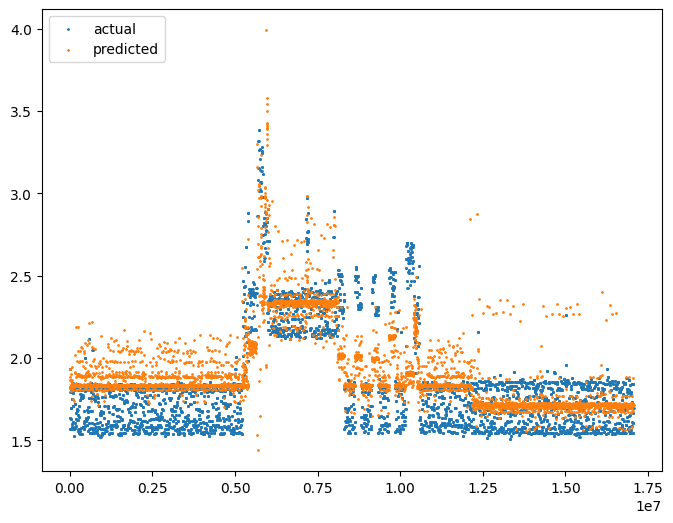

In [11]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

plt.scatter(memrate_df['time'], memrate_df['current'], label='actual', s=1)
plt.scatter(memrate_df['time'], predictions, label='predicted', s=1)
plt.legend(loc='upper left')

In [12]:
memrate_df = pd.read_csv('../results/numa-memthrash.csv')

memrate_df['cache_hit_rate_0'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_0']) / memrate_df['cache_hit_0']
memrate_df['cache_hit_rate_1'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_1']) / memrate_df['cache_hit_1']
memrate_df['cache_hit_rate_2'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_2']) / memrate_df['cache_hit_2']
memrate_df['cache_hit_rate_3'] = (memrate_df['cache_hit_0'] - memrate_df['cache_miss_3']) / memrate_df['cache_hit_3']

memrate_df['br_miss_rate_0'] = memrate_df['br_miss_0'] / memrate_df['br_insns_0']
memrate_df['br_miss_rate_1'] = memrate_df['br_miss_1'] / memrate_df['br_insns_1']
memrate_df['br_miss_rate_2'] = memrate_df['br_miss_2'] / memrate_df['br_insns_2']
memrate_df['br_miss_rate_3'] = memrate_df['br_miss_3'] / memrate_df['br_insns_3']

memrate_df['insns_0_norm'] = memrate_df['insns_0'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_1_norm'] = memrate_df['insns_1'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_2_norm'] = memrate_df['insns_2'] / (memrate_df['time'] - memrate_df['time'].shift())
memrate_df['insns_3_norm'] = memrate_df['insns_3'] / (memrate_df['time'] - memrate_df['time'].shift())

memrate_df = memrate_df.drop(index=0)
memrate_df

,time,current,cpu_cycles_0,insns_0,cache_hit_0,cache_miss_0,br_insns_0,br_miss_0,bus_cycles_0,freq_0,...,cache_hit_rate_2,cache_hit_rate_3,br_miss_rate_0,br_miss_rate_1,br_miss_rate_2,br_miss_rate_3,insns_0_norm,insns_1_norm,insns_2_norm,insns_3_norm
1,3541,1.888,36685,16175,5847,61,1531,246,9553,700000,...,1.858376,1.817926,0.160679,0.035728,0.149758,0.142410,7.742939,118.315941,4.214935,4.512207
2,5519,1.888,34437,15683,5802,42,1508,230,8714,700000,...,1.803622,1.806311,0.152520,0.033776,0.140845,0.139498,7.928716,116.972700,4.731547,4.721941
3,7500,1.888,38108,17719,6602,42,1759,273,10699,700000,...,2.056268,2.056232,0.155202,0.033488,0.136150,0.141066,8.944472,116.936901,4.708228,4.713276
4,9469,1.572,33761,15579,5768,43,1494,221,8494,700000,...,1.795561,1.796250,0.147925,0.033171,0.139280,0.137931,7.912138,116.614017,4.746064,4.737938
5,11493,1.572,28719,13012,4748,41,1150,163,5940,700000,...,1.476250,0.229538,0.141739,0.032971,0.137715,0.225047,6.428854,114.010375,4.630929,21.408103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10820,23559992,1.624,31033,14546,5265,41,1274,162,6412,700000,...,1.487216,1.490057,0.127159,0.030025,0.128205,0.132479,7.324270,118.055388,5.310171,5.314703
10821,23562093,1.624,32215,14587,5297,47,1277,164,6971,700000,...,1.495880,1.498295,0.128426,0.055045,0.128205,0.135328,6.942884,174.803427,5.024750,5.023798
10822,23564086,1.624,31207,14546,5266,39,1274,160,6437,700000,...,1.488630,1.505308,0.125589,0.034520,0.128205,0.127379,7.298545,119.893126,5.305569,4.969895
10823,23566068,1.588,31345,14549,5282,41,1277,163,6459,700000,...,1.493746,1.491074,0.127643,0.030868,0.128205,0.137394,7.340565,118.215439,5.337033,5.360747


In [13]:
X_test = memrate_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm', 'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = memrate_df['current']
predictions = model.predict(X_test)

In [14]:
mean_squared_error(Y_test, predictions)

0.13496043130213056

In [15]:
mean_absolute_error(Y_test, predictions)

0.2672853667571562

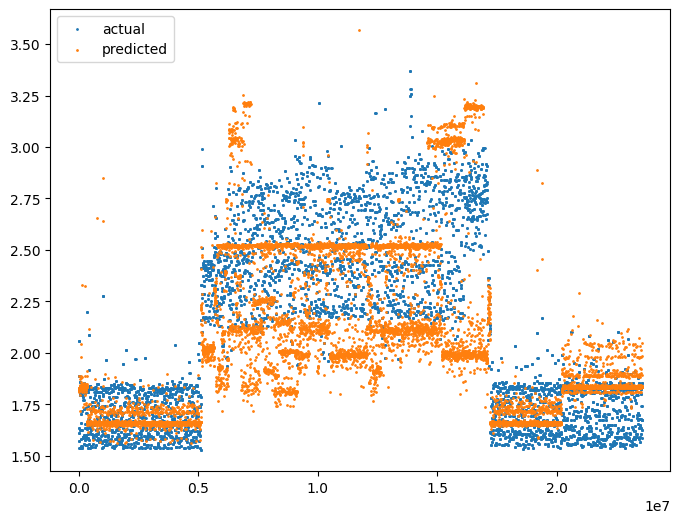

In [16]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

plt.scatter(memrate_df['time'], memrate_df['current'], label='actual', s=1)
plt.scatter(memrate_df['time'], predictions, label='predicted', s=1)
plt.legend(loc='upper left')